### Imports and Global Configuration

In [1]:
import datetime

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers, regularizers
import tensorflow.keras.backend as K
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# Constants across architectures
N_INPUT_CH = 22
N_PCA_COMP = 18
N_INPUT_SAMPLES = 1000
N_INPUT_SAMPLES_TRIMMED = 500
EPOCHS = 250

# Data loading
- Converts to 32-bit floats to reduce training time
- Adjusts labels to be in the range \[0-3\]
- Generates onehot encoded copies of all values that represent a class index

In [3]:
# Load the data and convert from 64 to 32 bit floats
X_train_valid = np.load("../data/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("../data/y_train_valid.npy").astype(np.float32)
X_test = np.load("../data/X_test.npy").astype(np.float32)
y_test = np.load("../data/y_test.npy").astype(np.float32)

# Swap the axes of our EEG signals so the channels are the last axis
X_train_valid = X_train_valid.transpose((0,2,1))
X_test = X_test.transpose((0,2,1))

# Split Train+Val data to Train and Val sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid,
    test_size=0.2, random_state=42)

# Print our the shapes of the data we loaded for confirmation
print ('Training data shape: {}'.format(X_train.shape))
print ('Validation data shape: {}'.format(X_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training target shape: {}'.format(y_train.shape))
print ('Validation target shape: {}'.format(y_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))

# Function to convert labels from single value class index to onehot vector
def convert_to_one_hot(in_arr):
    in_arr = in_arr.reshape((in_arr.shape[0],))
    in_arr = in_arr.astype(int)
    in_arr_1h = np.zeros((in_arr.size, in_arr.max()+1))
    in_arr_1h[np.arange(in_arr.size),in_arr] = 1
    return in_arr_1h

# Adjust the y labels to be in the range [0-3] and also generate equivalent onehot representations
y_train -= 769
y_valid -= 769
y_test -= 769
print('y_train:', y_train[:10])
print('y_valid:', y_valid[:10])
print('y_test:', y_test[:10])
y_train_1h = convert_to_one_hot(y_train)
y_valid_1h = convert_to_one_hot(y_valid)
y_test_1h = convert_to_one_hot(y_test)
print('y_train_1h:')
print(y_train_1h[:4])
print('y_valid_1h:')
print(y_valid_1h[:4])
print('y_test_1h:')
print(y_test_1h[:4])

Training data shape: (1692, 1000, 22)
Validation data shape: (423, 1000, 22)
Test data shape: (443, 1000, 22)
Training target shape: (1692,)
Validation target shape: (423,)
Test target shape: (443,)
y_train: [3. 1. 1. 1. 1. 1. 3. 1. 1. 2.]
y_valid: [0. 2. 1. 2. 2. 1. 2. 3. 0. 3.]
y_test: [1. 0. 2. 3. 3. 2. 2. 3. 3. 0.]
y_train_1h:
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
y_valid_1h:
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
y_test_1h:
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


# Data Augmentation

Augmenting the limited training data was critical to achieve high performance on our design. Below, the loaded data is augmented in-place before being passed to any network. Many approaches were tried, and not all resulted in performance changes.

### Beneficial Augmentations
Update these fields with actual numbers when we have models included. Comment out the relevant augmentation, then rerun training and report the difference in val and/or test accuracy.
- Cropping each time-series signal to just the first 500 samples (2 seconds) of data
    - Cropping the last 500 samples seemed to net worse performance, but both are higher than the baseline 1000 samples
- Normalizing each time-series signal to zero mean and unit variance
    - This is not the same as 'extracting the mean image' from homeworks - every signal of every channel is modified independently.
    - This is designed so that the time domain signals have more predictable statistics.

### Neutral or Deterimental Augmentations
- Adding channels that were filtered to only include \mu and \beta frequencies showed no performance improvement on any model. This tripled the number of channels in each example from 22 to 66.
    - The idea was to pass the neural network better features, since the \mu and \beta frequencies are purported to be highly correlated with movement.
    - The networks we tried probably had no problem learning matched filters for these frequencies if those are beneficial filters. The first layer kernels certainly have sufficient parameters to do this in all models.
- Adding examples with varying levels of Additive White Gaussian Noise (AWGN) had no effect on performance
    - The number of examples was increase 10x (up to 21150), where every set of examples had a fixed sigma used to generate AWGN added to all channels
    - This was designed as a mitigation against overfitting, but did not seem to help with the overfitting issue.

## Data Augmentation Implementation

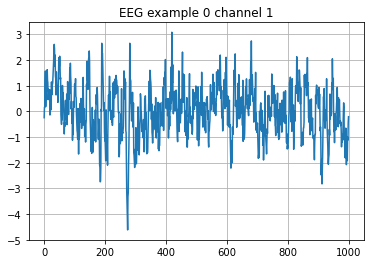

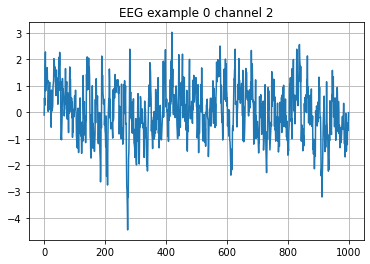

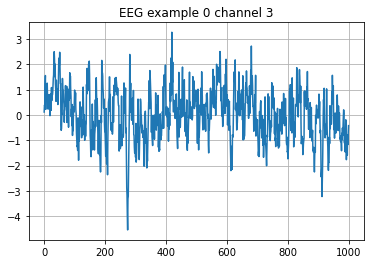

In [4]:
# Save copies of the original for the Baseline (Model 1)
X_train_baseline = np.copy(X_train)
X_valid_baseline = np.copy(X_valid)
X_test_baseline = np.copy(X_test)

# Normalize each time series signal of each channel to have zero mean and unit variance
# This is fine to do on the test set, since it is independent of example
samp_axis = 1
X_train -= np.expand_dims(np.mean(X_train, axis=samp_axis), samp_axis)
X_valid -= np.expand_dims(np.mean(X_valid, axis=samp_axis), samp_axis)
X_test -= np.expand_dims(np.mean(X_test, axis=samp_axis), samp_axis)
X_train /= np.expand_dims(np.std(X_train, axis=samp_axis), samp_axis)
X_valid /= np.expand_dims(np.std(X_valid, axis=samp_axis), samp_axis)
X_test /= np.expand_dims(np.std(X_test, axis=samp_axis), samp_axis)

# Generate some plots to visually verify
for i in range(3):
    plt.title("EEG example 0 channel %d" % (i+1))
    plt.plot(X_train[0,:,i])
    plt.grid()
    plt.show()

## PCA

In [5]:
# Generate a trimmed time series with the first 500 samples (2 seconds @ fs=250Hz)
# This seems to work better with PCA
X_train_trimmed = X_train[:,:N_INPUT_SAMPLES_TRIMMED,:]
X_valid_trimmed = X_valid[:,:N_INPUT_SAMPLES_TRIMMED,:]
X_test_trimmed = X_test[:,:N_INPUT_SAMPLES_TRIMMED,:]

# Merge the example and time axes, we want to drop channel dimensions
X_train_reshaped = X_train_trimmed.reshape(
    (X_train_trimmed.shape[0]*X_train_trimmed.shape[1], X_train_trimmed.shape[2]))

# Create a PCA instance and fit the training data
pca = PCA(n_components=N_PCA_COMP)
pca.fit(X_train_reshaped)
X_train_transformed = np.empty(
    (X_train_trimmed.shape[0], X_train_trimmed.shape[1], N_PCA_COMP))
for i in range(len(X_train_trimmed)):
    # Iteratively apply the transformation to each instance of the original dataset
    X_train_transformed[i] = pca.transform(X_train_trimmed[i])

# Apply the same transformation to the validation and test sets
X_valid_transformed = np.empty((X_valid_trimmed.shape[0], X_valid_trimmed.shape[1], N_PCA_COMP))
X_test_transformed = np.empty((X_test_trimmed.shape[0], X_test_trimmed.shape[1], N_PCA_COMP))
for i in range(len(X_valid)):
    X_valid_transformed[i] = pca.transform(X_valid_trimmed[i])
for i in range(len(X_test)):
    X_test_transformed[i] = pca.transform(X_test_trimmed[i])
    
# Print results as a sanity check
print ('Training data shape: {}'.format(X_train_transformed.shape))
print ('Validation data shape: {}'.format(X_valid_transformed.shape))
print ('Test data shape: {}'.format(X_test_transformed.shape))

Training data shape: (1692, 500, 18)
Validation data shape: (423, 500, 18)
Test data shape: (443, 500, 18)


# Models

## Model 1 - Baseline CNN

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_4 (Permute)          (None, 22, 1000)          0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 976, 40)       1040      
_________________________________________________________________
permute_5 (Permute)          (None, 976, 22, 40)       0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 976, 880)          0         
_________________________________________________________________
dense_4 (Dense)              (None, 976, 40)           35240     
_________________________________________________________________
activation_4 (Activation)    (None, 976, 40)          

Epoch 28/250

Epoch 00028: val_categorical_accuracy did not improve from 0.47518
14/14 - 1s - loss: 1.1706 - categorical_accuracy: 0.4959 - val_loss: 1.2277 - val_categorical_accuracy: 0.4681 - lr: 1.0000e-04
Epoch 29/250

Epoch 00029: val_categorical_accuracy improved from 0.47518 to 0.49882, saving model to best_cnn.h5
14/14 - 1s - loss: 1.1657 - categorical_accuracy: 0.5024 - val_loss: 1.2220 - val_categorical_accuracy: 0.4988 - lr: 1.0000e-04
Epoch 30/250

Epoch 00030: val_categorical_accuracy did not improve from 0.49882
14/14 - 1s - loss: 1.1744 - categorical_accuracy: 0.5012 - val_loss: 1.2171 - val_categorical_accuracy: 0.4870 - lr: 1.0000e-04
Epoch 31/250

Epoch 00031: val_categorical_accuracy improved from 0.49882 to 0.50827, saving model to best_cnn.h5
14/14 - 1s - loss: 1.1527 - categorical_accuracy: 0.5089 - val_loss: 1.2137 - val_categorical_accuracy: 0.5083 - lr: 1.0000e-04
Epoch 32/250

Epoch 00032: val_categorical_accuracy did not improve from 0.50827
14/14 - 1s - loss

Epoch 65/250

Epoch 00065: val_categorical_accuracy did not improve from 0.59338
14/14 - 1s - loss: 0.8956 - categorical_accuracy: 0.6590 - val_loss: 1.0418 - val_categorical_accuracy: 0.5816 - lr: 1.0000e-04
Epoch 66/250

Epoch 00066: val_categorical_accuracy did not improve from 0.59338
14/14 - 1s - loss: 0.8863 - categorical_accuracy: 0.6613 - val_loss: 1.0396 - val_categorical_accuracy: 0.5839 - lr: 1.0000e-04
Epoch 67/250

Epoch 00067: val_categorical_accuracy did not improve from 0.59338
14/14 - 1s - loss: 0.8760 - categorical_accuracy: 0.6637 - val_loss: 1.0338 - val_categorical_accuracy: 0.5745 - lr: 1.0000e-04
Epoch 68/250

Epoch 00068: val_categorical_accuracy did not improve from 0.59338
14/14 - 1s - loss: 0.8637 - categorical_accuracy: 0.6820 - val_loss: 1.0276 - val_categorical_accuracy: 0.5887 - lr: 1.0000e-04
Epoch 69/250

Epoch 00069: val_categorical_accuracy did not improve from 0.59338
14/14 - 1s - loss: 0.8767 - categorical_accuracy: 0.6655 - val_loss: 1.0296 - val_c

Epoch 103/250

Epoch 00103: val_categorical_accuracy did not improve from 0.63121
14/14 - 1s - loss: 0.7334 - categorical_accuracy: 0.7364 - val_loss: 0.9565 - val_categorical_accuracy: 0.6288 - lr: 1.0000e-04
Epoch 104/250

Epoch 00104: val_categorical_accuracy did not improve from 0.63121
14/14 - 1s - loss: 0.7467 - categorical_accuracy: 0.7311 - val_loss: 0.9596 - val_categorical_accuracy: 0.6312 - lr: 1.0000e-04
Epoch 105/250

Epoch 00105: val_categorical_accuracy did not improve from 0.63121
14/14 - 1s - loss: 0.7308 - categorical_accuracy: 0.7293 - val_loss: 0.9519 - val_categorical_accuracy: 0.6312 - lr: 1.0000e-04
Epoch 106/250

Epoch 00106: val_categorical_accuracy did not improve from 0.63121
14/14 - 1s - loss: 0.7052 - categorical_accuracy: 0.7476 - val_loss: 0.9506 - val_categorical_accuracy: 0.6312 - lr: 1.0000e-04
Epoch 107/250

Epoch 00107: val_categorical_accuracy did not improve from 0.63121
14/14 - 1s - loss: 0.7402 - categorical_accuracy: 0.7311 - val_loss: 0.9465 - 

Epoch 142/250

Epoch 00142: val_categorical_accuracy did not improve from 0.65721
14/14 - 1s - loss: 0.6605 - categorical_accuracy: 0.7636 - val_loss: 0.9021 - val_categorical_accuracy: 0.6383 - lr: 1.0000e-04
Epoch 143/250

Epoch 00143: val_categorical_accuracy did not improve from 0.65721
14/14 - 1s - loss: 0.6634 - categorical_accuracy: 0.7571 - val_loss: 0.9019 - val_categorical_accuracy: 0.6478 - lr: 1.0000e-04
Epoch 144/250

Epoch 00144: val_categorical_accuracy did not improve from 0.65721
14/14 - 1s - loss: 0.6315 - categorical_accuracy: 0.7931 - val_loss: 0.9093 - val_categorical_accuracy: 0.6525 - lr: 1.0000e-04
Epoch 145/250

Epoch 00145: val_categorical_accuracy did not improve from 0.65721
14/14 - 1s - loss: 0.6484 - categorical_accuracy: 0.7707 - val_loss: 0.9027 - val_categorical_accuracy: 0.6383 - lr: 1.0000e-04
Epoch 146/250

Epoch 00146: val_categorical_accuracy did not improve from 0.65721
14/14 - 1s - loss: 0.6323 - categorical_accuracy: 0.7742 - val_loss: 0.8986 - 

Epoch 181/250

Epoch 00181: val_categorical_accuracy did not improve from 0.68322
14/14 - 1s - loss: 0.5828 - categorical_accuracy: 0.8026 - val_loss: 0.8904 - val_categorical_accuracy: 0.6478 - lr: 1.0000e-04
Epoch 182/250

Epoch 00182: val_categorical_accuracy did not improve from 0.68322
14/14 - 1s - loss: 0.5856 - categorical_accuracy: 0.7914 - val_loss: 0.8965 - val_categorical_accuracy: 0.6501 - lr: 1.0000e-04
Epoch 183/250

Epoch 00183: val_categorical_accuracy did not improve from 0.68322
14/14 - 1s - loss: 0.5762 - categorical_accuracy: 0.8050 - val_loss: 0.8792 - val_categorical_accuracy: 0.6738 - lr: 1.0000e-04
Epoch 184/250

Epoch 00184: val_categorical_accuracy did not improve from 0.68322
14/14 - 1s - loss: 0.5776 - categorical_accuracy: 0.8020 - val_loss: 0.8833 - val_categorical_accuracy: 0.6714 - lr: 1.0000e-04
Epoch 185/250

Epoch 00185: val_categorical_accuracy did not improve from 0.68322
14/14 - 1s - loss: 0.5697 - categorical_accuracy: 0.8085 - val_loss: 0.8962 - 

Epoch 220/250

Epoch 00220: val_categorical_accuracy did not improve from 0.68794
14/14 - 1s - loss: 0.5106 - categorical_accuracy: 0.8345 - val_loss: 0.8706 - val_categorical_accuracy: 0.6643 - lr: 5.0000e-05
Epoch 221/250

Epoch 00221: val_categorical_accuracy did not improve from 0.68794
14/14 - 1s - loss: 0.5112 - categorical_accuracy: 0.8416 - val_loss: 0.8654 - val_categorical_accuracy: 0.6619 - lr: 5.0000e-05
Epoch 222/250

Epoch 00222: val_categorical_accuracy did not improve from 0.68794
14/14 - 1s - loss: 0.5091 - categorical_accuracy: 0.8292 - val_loss: 0.8675 - val_categorical_accuracy: 0.6643 - lr: 5.0000e-05
Epoch 223/250

Epoch 00223: val_categorical_accuracy did not improve from 0.68794
14/14 - 1s - loss: 0.4982 - categorical_accuracy: 0.8375 - val_loss: 0.8709 - val_categorical_accuracy: 0.6714 - lr: 5.0000e-05
Epoch 224/250

Epoch 00224: val_categorical_accuracy did not improve from 0.68794
14/14 - 1s - loss: 0.5074 - categorical_accuracy: 0.8333 - val_loss: 0.8689 - 

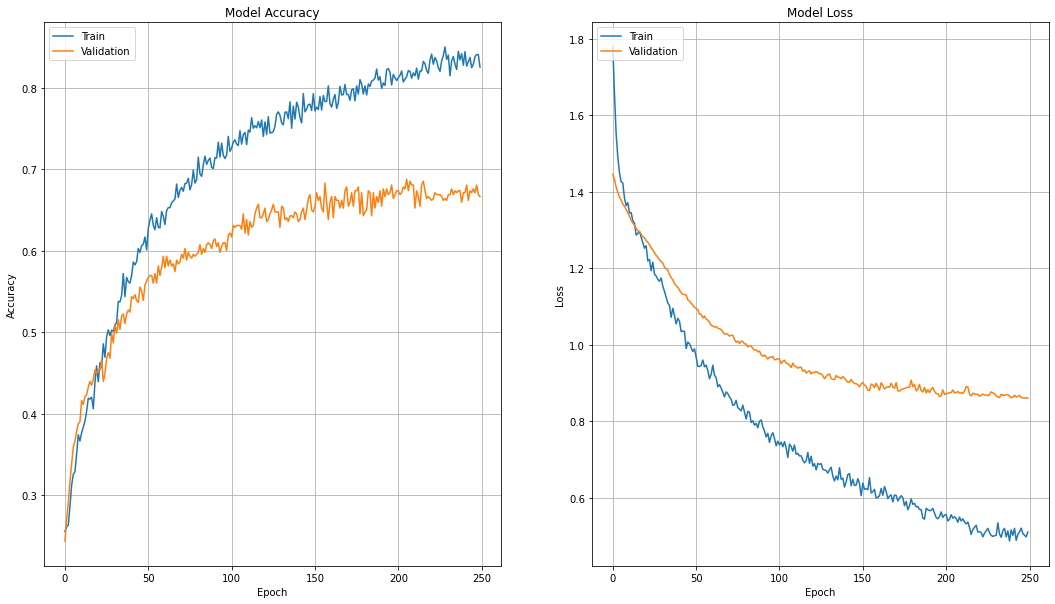

In [10]:
# Tweakable hyperparameters
n_filters = [40]
conv_sizes = [(1, 25)]
fc_sizes = [40, 4]
pool_sizes = [75]
pool_strides = [15]
fc_dropout = 0.8

# Model architecture
model = tf.keras.Sequential()
model.add(layers.Input((N_INPUT_SAMPLES, N_INPUT_CH)))
model.add(layers.Permute((2, 1)))
model.add(layers.Reshape(
    (N_INPUT_CH, N_INPUT_SAMPLES, 1)))
model.add(layers.Conv2D(
    filters=n_filters[0], kernel_size=conv_sizes[0],
    kernel_regularizer='l2',
    activation='elu'
))
model.add(layers.Permute((2, 1, 3)))
model.add(layers.Reshape(
    (N_INPUT_SAMPLES-conv_sizes[0][1]+1, N_INPUT_CH*n_filters[0])))
model.add(layers.Dense(fc_sizes[0], activation='elu'))
model.add(layers.Activation(lambda x: tf.pow(x, 2)))
model.add(layers.AveragePooling1D(pool_sizes[0], strides=pool_strides[0]))
model.add(layers.Activation(lambda x: tf.math.log(x)))
model.add(layers.Flatten())
model.add(layers.Dropout(fc_dropout))
model.add(layers.Dense(
    fc_sizes[1],
    activation='softmax',
    kernel_regularizer='l2',
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)
))

# Compile model, using ADAM as the optimizer. Provide a summary once compiled.
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()

# Train our network with an 80/20 train/val split
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=20, factor=0.5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_cnn.h5', 
        save_best_only=True,
        verbose=True,
        monitor='val_categorical_accuracy'
    ),
]
loss_hist = model.fit(
    X_train_baseline, y_train_1h,
    validation_data=(X_valid_baseline, y_valid_1h),
    batch_size=128,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks
)

# Load our best weights and evaluate model on test dataset
model.load_weights('best_cnn.h5')
print('\nTest accuracy')
print(model.evaluate(X_test_baseline, y_test_1h))

# Plot our loss and accuracy over time
fig, axs = plt.subplots(1,2, figsize=(18, 10))
axs[0].plot(loss_hist.history['categorical_accuracy'])
axs[0].plot(loss_hist.history['val_categorical_accuracy'])
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Model Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')
axs[0].grid()
axs[1].plot(loss_hist.history['loss'])
axs[1].plot(loss_hist.history['val_loss'])
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Model Loss')
axs[1].legend(['Train', 'Validation'], loc='upper left')
axs[1].grid()
plt.show()

## Model 2 - Baseline CNN with PCA and Optimal Preprocessing

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 18)]         0         
_________________________________________________________________
permute_2 (Permute)          (None, 18, 500)           0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 18, 500, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 476, 40)       1040      
_________________________________________________________________
permute_3 (Permute)          (None, 476, 18, 40)       0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 476, 720)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 476, 40)           28840 

Epoch 28/250

Epoch 00028: val_categorical_accuracy improved from 0.63357 to 0.63830, saving model to best_tweaked_cnn.h5
14/14 - 0s - loss: 0.8808 - categorical_accuracy: 0.6548 - val_loss: 0.9039 - val_categorical_accuracy: 0.6383 - lr: 0.0010
Epoch 29/250

Epoch 00029: val_categorical_accuracy did not improve from 0.63830
14/14 - 0s - loss: 0.8321 - categorical_accuracy: 0.6939 - val_loss: 0.8939 - val_categorical_accuracy: 0.6265 - lr: 0.0010
Epoch 30/250

Epoch 00030: val_categorical_accuracy improved from 0.63830 to 0.65248, saving model to best_tweaked_cnn.h5
14/14 - 0s - loss: 0.8407 - categorical_accuracy: 0.6850 - val_loss: 0.9027 - val_categorical_accuracy: 0.6525 - lr: 0.0010
Epoch 31/250

Epoch 00031: val_categorical_accuracy did not improve from 0.65248
14/14 - 0s - loss: 0.8311 - categorical_accuracy: 0.7033 - val_loss: 0.8811 - val_categorical_accuracy: 0.6288 - lr: 0.0010
Epoch 32/250

Epoch 00032: val_categorical_accuracy improved from 0.65248 to 0.67139, saving model

Epoch 67/250

Epoch 00067: val_categorical_accuracy did not improve from 0.69740
14/14 - 0s - loss: 0.6641 - categorical_accuracy: 0.7719 - val_loss: 0.8251 - val_categorical_accuracy: 0.6950 - lr: 0.0010
Epoch 68/250

Epoch 00068: val_categorical_accuracy did not improve from 0.69740
14/14 - 0s - loss: 0.6632 - categorical_accuracy: 0.7583 - val_loss: 0.8248 - val_categorical_accuracy: 0.6785 - lr: 0.0010
Epoch 69/250

Epoch 00069: val_categorical_accuracy did not improve from 0.69740
14/14 - 0s - loss: 0.6678 - categorical_accuracy: 0.7701 - val_loss: 0.8306 - val_categorical_accuracy: 0.6974 - lr: 0.0010
Epoch 70/250

Epoch 00070: val_categorical_accuracy did not improve from 0.69740
14/14 - 0s - loss: 0.6483 - categorical_accuracy: 0.7636 - val_loss: 0.8241 - val_categorical_accuracy: 0.6879 - lr: 0.0010
Epoch 71/250

Epoch 00071: val_categorical_accuracy did not improve from 0.69740
14/14 - 0s - loss: 0.6726 - categorical_accuracy: 0.7730 - val_loss: 0.8251 - val_categorical_accur

Epoch 106/250

Epoch 00106: val_categorical_accuracy did not improve from 0.71395
14/14 - 0s - loss: 0.5820 - categorical_accuracy: 0.8032 - val_loss: 0.8066 - val_categorical_accuracy: 0.6903 - lr: 5.0000e-04
Epoch 107/250

Epoch 00107: val_categorical_accuracy did not improve from 0.71395
14/14 - 0s - loss: 0.6095 - categorical_accuracy: 0.7878 - val_loss: 0.8057 - val_categorical_accuracy: 0.6974 - lr: 5.0000e-04
Epoch 108/250

Epoch 00108: val_categorical_accuracy did not improve from 0.71395
14/14 - 0s - loss: 0.5855 - categorical_accuracy: 0.7949 - val_loss: 0.8005 - val_categorical_accuracy: 0.6903 - lr: 5.0000e-04
Epoch 109/250

Epoch 00109: val_categorical_accuracy did not improve from 0.71395
14/14 - 0s - loss: 0.5902 - categorical_accuracy: 0.7926 - val_loss: 0.8121 - val_categorical_accuracy: 0.6998 - lr: 5.0000e-04
Epoch 110/250

Epoch 00110: val_categorical_accuracy did not improve from 0.71395
14/14 - 0s - loss: 0.6036 - categorical_accuracy: 0.7943 - val_loss: 0.8055 - 

Epoch 145/250

Epoch 00145: val_categorical_accuracy did not improve from 0.71868
14/14 - 0s - loss: 0.5724 - categorical_accuracy: 0.8085 - val_loss: 0.8149 - val_categorical_accuracy: 0.7092 - lr: 2.5000e-04
Epoch 146/250

Epoch 00146: val_categorical_accuracy did not improve from 0.71868
14/14 - 0s - loss: 0.5526 - categorical_accuracy: 0.8132 - val_loss: 0.8113 - val_categorical_accuracy: 0.7069 - lr: 2.5000e-04
Epoch 147/250

Epoch 00147: val_categorical_accuracy did not improve from 0.71868
14/14 - 0s - loss: 0.5240 - categorical_accuracy: 0.8209 - val_loss: 0.8045 - val_categorical_accuracy: 0.7045 - lr: 2.5000e-04
Epoch 148/250

Epoch 00148: val_categorical_accuracy did not improve from 0.71868
14/14 - 0s - loss: 0.5480 - categorical_accuracy: 0.7967 - val_loss: 0.8117 - val_categorical_accuracy: 0.7045 - lr: 2.5000e-04
Epoch 149/250

Epoch 00149: val_categorical_accuracy did not improve from 0.71868
14/14 - 0s - loss: 0.5738 - categorical_accuracy: 0.8056 - val_loss: 0.8112 - 


Epoch 00184: val_categorical_accuracy did not improve from 0.71868
14/14 - 0s - loss: 0.5094 - categorical_accuracy: 0.8381 - val_loss: 0.8066 - val_categorical_accuracy: 0.7139 - lr: 6.2500e-05
Epoch 185/250

Epoch 00185: val_categorical_accuracy did not improve from 0.71868
14/14 - 0s - loss: 0.5573 - categorical_accuracy: 0.7985 - val_loss: 0.8051 - val_categorical_accuracy: 0.7116 - lr: 6.2500e-05
Epoch 186/250

Epoch 00186: val_categorical_accuracy did not improve from 0.71868
14/14 - 0s - loss: 0.5245 - categorical_accuracy: 0.8363 - val_loss: 0.8053 - val_categorical_accuracy: 0.7069 - lr: 6.2500e-05
Epoch 187/250

Epoch 00187: val_categorical_accuracy did not improve from 0.71868
14/14 - 0s - loss: 0.5371 - categorical_accuracy: 0.8144 - val_loss: 0.8051 - val_categorical_accuracy: 0.7116 - lr: 6.2500e-05
Epoch 188/250

Epoch 00188: val_categorical_accuracy did not improve from 0.71868
14/14 - 0s - loss: 0.5502 - categorical_accuracy: 0.8162 - val_loss: 0.8072 - val_categorica

Epoch 223/250

Epoch 00223: val_categorical_accuracy did not improve from 0.72104
14/14 - 0s - loss: 0.5308 - categorical_accuracy: 0.8197 - val_loss: 0.8003 - val_categorical_accuracy: 0.7116 - lr: 1.5625e-05
Epoch 224/250

Epoch 00224: val_categorical_accuracy did not improve from 0.72104
14/14 - 0s - loss: 0.5219 - categorical_accuracy: 0.8298 - val_loss: 0.8001 - val_categorical_accuracy: 0.7116 - lr: 1.5625e-05
Epoch 225/250

Epoch 00225: val_categorical_accuracy did not improve from 0.72104
14/14 - 0s - loss: 0.5184 - categorical_accuracy: 0.8298 - val_loss: 0.7995 - val_categorical_accuracy: 0.7092 - lr: 1.5625e-05
Epoch 226/250

Epoch 00226: val_categorical_accuracy did not improve from 0.72104
14/14 - 0s - loss: 0.5282 - categorical_accuracy: 0.8162 - val_loss: 0.7997 - val_categorical_accuracy: 0.7069 - lr: 1.5625e-05
Epoch 227/250

Epoch 00227: val_categorical_accuracy did not improve from 0.72104
14/14 - 0s - loss: 0.5324 - categorical_accuracy: 0.8233 - val_loss: 0.8000 - 

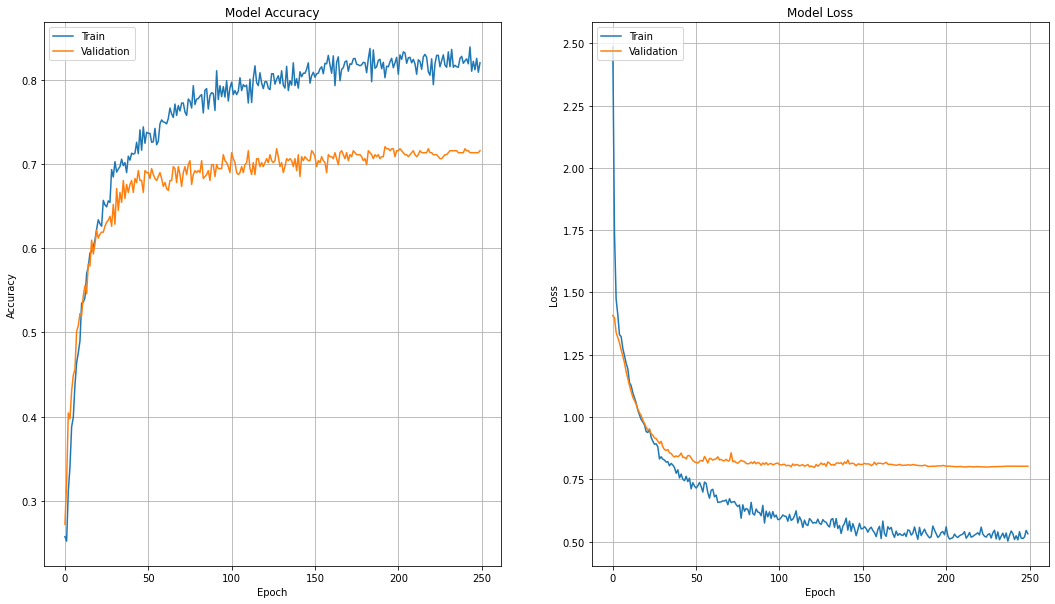

In [7]:
def ksquare(x):
    return tf.pow(x, 2)

def klog(x):
    return tf.math.log(x)

# Model architecture
input_ = layers.Input(shape=(N_INPUT_SAMPLES_TRIMMED, N_PCA_COMP))
p0 = layers.Permute(dims=(2,1))(input_)
r1 = layers.Reshape(target_shape=(N_PCA_COMP, N_INPUT_SAMPLES_TRIMMED, 1))(p0)
c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                   activation='elu', kernel_regularizer='l2')(r1)
p1 = layers.Permute(dims=(2,1,3))(c1)
r2 = layers.Reshape((476, N_PCA_COMP*40))(p1)
d1 = layers.Dense(40, activation='elu')(r2)
sq1 = layers.Activation(ksquare)(d1)
ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
log1 = layers.Activation(klog)(ap1)
f1 = layers.Flatten()(log1)
d2 = layers.Dropout(0.85)(f1)
output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)

# Compile model, using ADAM as the optimizer. Provide a summary once compiled.
model = tf.keras.models.Model(inputs=input_, outputs=output_)
model.compile(optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()

# Train our network with an 80/20 train/val split
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=20, factor=0.5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_tweaked_cnn.h5', 
        save_best_only=True,
        verbose=True,
        monitor='val_categorical_accuracy'
    ),
]
loss_hist = model.fit(
    X_train_transformed, y_train_1h,
    validation_data=(X_valid_transformed, y_valid_1h),
    batch_size=128,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks
)

# Load our best weights and evaluate model on test dataset
model.load_weights('best_tweaked_cnn.h5')
print('\nTest accuracy')
print(model.evaluate(X_test_transformed, y_test_1h))

# Plot our loss and accuracy over time
fig, axs = plt.subplots(1,2, figsize=(18, 10))
axs[0].plot(loss_hist.history['categorical_accuracy'])
axs[0].plot(loss_hist.history['val_categorical_accuracy'])
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Model Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')
axs[0].grid()
axs[1].plot(loss_hist.history['loss'])
axs[1].plot(loss_hist.history['val_loss'])
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Model Loss')
axs[1].legend(['Train', 'Validation'], loc='upper left')
axs[1].grid()
plt.show()

## Model 3 - SCNN

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 1000, 22, 1)       0         
_________________________________________________________________
spatial_conv_0 (Conv2D)      (None, 1000, 12, 100)     1100      
_________________________________________________________________
spatial_conv_1 (Conv2D)      (None, 1000, 1, 100)      120000    
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 1, 100)      400       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 1000, 1, 100)      0         
_________________________________________________________________
temporal_conv_0 (Conv2D)     (None, 977, 1, 40)        9600

Epoch 28/250

Epoch 00028: val_categorical_accuracy did not improve from 0.60993
27/27 - 1s - loss: 0.7919 - categorical_accuracy: 0.9285 - val_loss: 1.6430 - val_categorical_accuracy: 0.5887 - lr: 5.0000e-04
Epoch 29/250

Epoch 00029: val_categorical_accuracy did not improve from 0.60993
27/27 - 1s - loss: 0.7620 - categorical_accuracy: 0.9297 - val_loss: 1.6890 - val_categorical_accuracy: 0.5768 - lr: 5.0000e-04
Epoch 30/250

Epoch 00030: val_categorical_accuracy did not improve from 0.60993
27/27 - 1s - loss: 0.7720 - categorical_accuracy: 0.9238 - val_loss: 1.5845 - val_categorical_accuracy: 0.5981 - lr: 5.0000e-04
Epoch 31/250

Epoch 00031: val_categorical_accuracy did not improve from 0.60993
27/27 - 1s - loss: 0.7275 - categorical_accuracy: 0.9320 - val_loss: 1.6766 - val_categorical_accuracy: 0.5626 - lr: 5.0000e-04
Epoch 32/250

Epoch 00032: val_categorical_accuracy did not improve from 0.60993
27/27 - 1s - loss: 0.6826 - categorical_accuracy: 0.9450 - val_loss: 1.5872 - val_c

Epoch 67/250

Epoch 00067: val_categorical_accuracy did not improve from 0.64303
27/27 - 1s - loss: 0.4373 - categorical_accuracy: 0.9557 - val_loss: 1.5584 - val_categorical_accuracy: 0.5863 - lr: 5.0000e-04
Epoch 68/250

Epoch 00068: val_categorical_accuracy did not improve from 0.64303
27/27 - 1s - loss: 0.4454 - categorical_accuracy: 0.9563 - val_loss: 1.6968 - val_categorical_accuracy: 0.5697 - lr: 5.0000e-04
Epoch 69/250

Epoch 00069: val_categorical_accuracy did not improve from 0.64303
27/27 - 1s - loss: 0.4083 - categorical_accuracy: 0.9764 - val_loss: 1.6340 - val_categorical_accuracy: 0.5674 - lr: 5.0000e-04
Epoch 70/250

Epoch 00070: val_categorical_accuracy did not improve from 0.64303
27/27 - 1s - loss: 0.3969 - categorical_accuracy: 0.9722 - val_loss: 1.4480 - val_categorical_accuracy: 0.6005 - lr: 5.0000e-04
Epoch 71/250

Epoch 00071: val_categorical_accuracy did not improve from 0.64303
27/27 - 1s - loss: 0.3915 - categorical_accuracy: 0.9699 - val_loss: 1.7760 - val_c


Epoch 00106: val_categorical_accuracy did not improve from 0.65012
27/27 - 1s - loss: 0.2168 - categorical_accuracy: 0.9976 - val_loss: 1.2854 - val_categorical_accuracy: 0.6430 - lr: 1.2500e-04
Epoch 107/250

Epoch 00107: val_categorical_accuracy did not improve from 0.65012
27/27 - 1s - loss: 0.2150 - categorical_accuracy: 0.9988 - val_loss: 1.2646 - val_categorical_accuracy: 0.6194 - lr: 1.2500e-04
Epoch 108/250

Epoch 00108: val_categorical_accuracy did not improve from 0.65012
27/27 - 1s - loss: 0.2122 - categorical_accuracy: 0.9982 - val_loss: 1.1975 - val_categorical_accuracy: 0.6383 - lr: 1.2500e-04
Epoch 109/250

Epoch 00109: val_categorical_accuracy did not improve from 0.65012
27/27 - 1s - loss: 0.2104 - categorical_accuracy: 0.9982 - val_loss: 1.3160 - val_categorical_accuracy: 0.6336 - lr: 1.2500e-04
Epoch 110/250

Epoch 00110: val_categorical_accuracy did not improve from 0.65012
27/27 - 1s - loss: 0.2094 - categorical_accuracy: 0.9988 - val_loss: 1.2725 - val_categorica

Epoch 146/250

Epoch 00146: val_categorical_accuracy did not improve from 0.65012
27/27 - 1s - loss: 0.1772 - categorical_accuracy: 0.9970 - val_loss: 1.3382 - val_categorical_accuracy: 0.6194 - lr: 6.2500e-05
Epoch 147/250

Epoch 00147: val_categorical_accuracy did not improve from 0.65012
27/27 - 1s - loss: 0.1721 - categorical_accuracy: 0.9982 - val_loss: 1.2511 - val_categorical_accuracy: 0.6265 - lr: 6.2500e-05
Epoch 148/250

Epoch 00148: val_categorical_accuracy did not improve from 0.65012
27/27 - 1s - loss: 0.1713 - categorical_accuracy: 0.9988 - val_loss: 1.2116 - val_categorical_accuracy: 0.6454 - lr: 6.2500e-05
Epoch 149/250

Epoch 00149: val_categorical_accuracy did not improve from 0.65012
27/27 - 1s - loss: 0.1739 - categorical_accuracy: 0.9965 - val_loss: 1.2479 - val_categorical_accuracy: 0.6288 - lr: 6.2500e-05
Epoch 150/250

Epoch 00150: val_categorical_accuracy did not improve from 0.65012
27/27 - 1s - loss: 0.1708 - categorical_accuracy: 0.9994 - val_loss: 1.2467 - 

Epoch 185/250

Epoch 00185: val_categorical_accuracy did not improve from 0.66430
27/27 - 1s - loss: 0.1530 - categorical_accuracy: 0.9988 - val_loss: 1.3152 - val_categorical_accuracy: 0.6170 - lr: 3.1250e-05
Epoch 186/250

Epoch 00186: val_categorical_accuracy did not improve from 0.66430
27/27 - 1s - loss: 0.1490 - categorical_accuracy: 1.0000 - val_loss: 1.2314 - val_categorical_accuracy: 0.6407 - lr: 3.1250e-05
Epoch 187/250

Epoch 00187: val_categorical_accuracy did not improve from 0.66430
27/27 - 1s - loss: 0.1514 - categorical_accuracy: 1.0000 - val_loss: 1.2040 - val_categorical_accuracy: 0.6383 - lr: 3.1250e-05
Epoch 188/250

Epoch 00188: val_categorical_accuracy did not improve from 0.66430
27/27 - 1s - loss: 0.1506 - categorical_accuracy: 0.9982 - val_loss: 1.3896 - val_categorical_accuracy: 0.6170 - lr: 3.1250e-05
Epoch 189/250

Epoch 00189: val_categorical_accuracy did not improve from 0.66430
27/27 - 1s - loss: 0.1491 - categorical_accuracy: 0.9994 - val_loss: 1.2920 - 


Epoch 00224: val_categorical_accuracy did not improve from 0.66430
27/27 - 1s - loss: 0.1389 - categorical_accuracy: 1.0000 - val_loss: 1.3632 - val_categorical_accuracy: 0.6099 - lr: 7.8125e-06
Epoch 225/250

Epoch 00225: val_categorical_accuracy did not improve from 0.66430
27/27 - 1s - loss: 0.1398 - categorical_accuracy: 0.9994 - val_loss: 1.1919 - val_categorical_accuracy: 0.6288 - lr: 7.8125e-06
Epoch 226/250

Epoch 00226: val_categorical_accuracy did not improve from 0.66430
27/27 - 1s - loss: 0.1374 - categorical_accuracy: 1.0000 - val_loss: 1.1709 - val_categorical_accuracy: 0.6336 - lr: 7.8125e-06
Epoch 227/250

Epoch 00227: val_categorical_accuracy did not improve from 0.66430
27/27 - 1s - loss: 0.1380 - categorical_accuracy: 1.0000 - val_loss: 1.1624 - val_categorical_accuracy: 0.6312 - lr: 7.8125e-06
Epoch 228/250

Epoch 00228: val_categorical_accuracy did not improve from 0.66430
27/27 - 1s - loss: 0.1365 - categorical_accuracy: 1.0000 - val_loss: 1.2040 - val_categorica

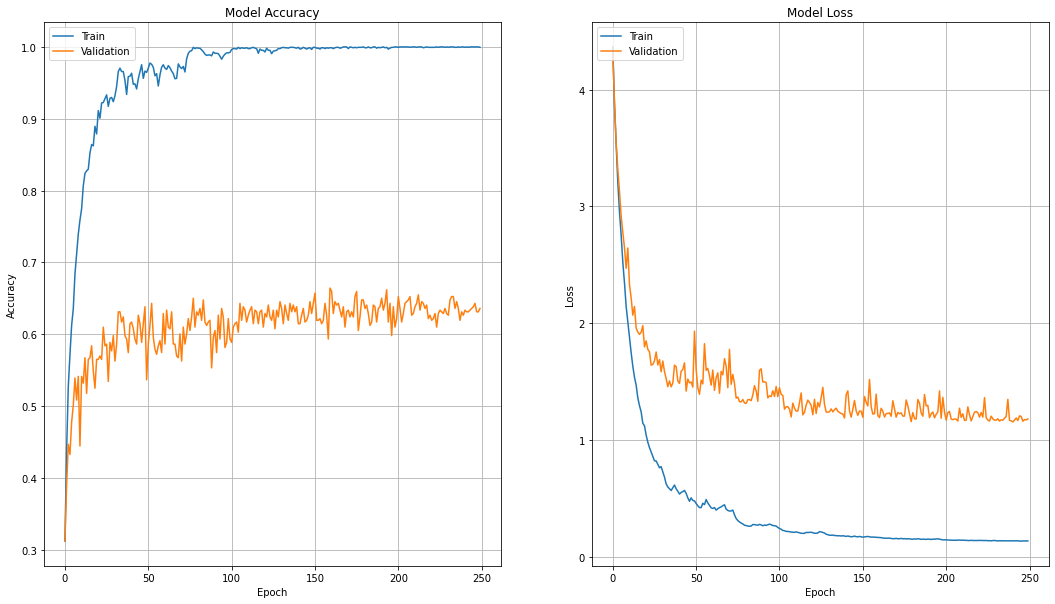

In [8]:
# Model Architecture
def SCNN(inputshape, outputshape, params=None):

    params = dict() if params is None else params

    temp_layers = int(params.get('temp_layers', 4))
    steps = int(params.get('steps', 2))
    temporal = int(params.get('temporal', 24))
    temp_pool = int(params.get('temp_pool', 20))
    lunits = [int(x) for x in params.get('lunits', [200, 40])]
    activation = params.get('activation', keras.activations.selu)
    reg = float(params.get('regularization', 0.01))
    do = min(1., max(0., float(params.get('dropout', 0.55))))

    convs = [inputshape[-1] // steps for _ in range(1, steps)]
    convs += [inputshape[-1] - sum(convs) + len(convs)]

    ins = keras.layers.Input(inputshape)
    conv = keras.layers.Reshape((inputshape[0], inputshape[1], 1))(ins)

    for i, c in enumerate(convs):
        conv = keras.layers.Conv2D(
            lunits[0] // len(convs), (1, c),
            activation=activation,
            use_bias=False, 
            name='spatial_conv_{0}'.format(i),
            kernel_regularizer=tf.keras.regularizers.l2(reg),
            data_format='channels_last')(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.SpatialDropout2D(do/2)(conv)

    for i in range(temp_layers):
        conv = keras.layers.Conv2D(
            lunits[1], (temporal, 1),
            activation=activation,
            use_bias=False, name='temporal_conv_{0}'.format(i),
            kernel_regularizer=tf.keras.regularizers.l2(reg),
            data_format='channels_last')(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.AveragePooling2D((temp_pool, 1))(conv)
    conv = keras.layers.SpatialDropout2D(do/2)(conv)

    outs = keras.layers.Flatten()(conv)

    for units in lunits[2:]:
        outs = keras.layers.Dense(
            units, activation=activation,
            kernel_regularizer=keras.layers.regularizers.l2(reg))(outs)
        outs = keras.layers.BatchNormalization()(outs)
        outs = keras.layers.Dropout(do)(outs)
    outs = keras.layers.Dense(
        outputshape, activation='softmax', name='OUT',
        kernel_regularizer=tf.keras.regularizers.l2(reg))(outs)

    return keras.models.Model(ins, outs)


# Compile model, using ADAM as the optimizer. Provide a summary once compiled.
model = SCNN(inputshape=(N_INPUT_SAMPLES, N_INPUT_CH), outputshape=4)
model.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()

# Train our network with an 80/20 train/val split
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=20, factor=0.5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_scnn.h5', 
        save_best_only=True,
        verbose=True,
        monitor='val_categorical_accuracy'
    ),
]
loss_hist = model.fit(
    X_train, y_train_1h,
    validation_data=(X_valid, y_valid_1h),
    batch_size=64,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
)

# Load our best weights and evaluate model on test dataset
model.load_weights('best_scnn.h5')
print('\nTest accuracy')
print(model.evaluate(X_test, y_test_1h))

# Plot our loss and accuracy over time
fig, axs = plt.subplots(1,2, figsize=(18, 10))
axs[0].plot(loss_hist.history['categorical_accuracy'])
axs[0].plot(loss_hist.history['val_categorical_accuracy'])
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Model Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')
axs[0].grid()
axs[1].plot(loss_hist.history['loss'])
axs[1].plot(loss_hist.history['val_loss'])
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Model Loss')
axs[1].legend(['Train', 'Validation'], loc='upper left')
axs[1].grid()
plt.show()

## Model 4 - SCNN+LSTM

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 1000, 22, 1)       0         
_________________________________________________________________
spatial_conv_0 (Conv2D)      (None, 1000, 12, 100)     1100      
_________________________________________________________________
spatial_conv_1 (Conv2D)      (None, 1000, 1, 100)      120000    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 1, 100)      400       
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 1000, 1, 100)      0         
_________________________________________________________________
temporal_conv_0 (Conv2D)     (None, 977, 1, 40)        9600

Epoch 27/250

Epoch 00027: val_categorical_accuracy improved from 0.62175 to 0.65485, saving model to best_rescnn.h5
27/27 - 1s - loss: 2.6486 - categorical_accuracy: 0.8280 - val_loss: 3.0670 - val_categorical_accuracy: 0.6548 - lr: 1.0000e-04
Epoch 28/250

Epoch 00028: val_categorical_accuracy did not improve from 0.65485
27/27 - 1s - loss: 2.6378 - categorical_accuracy: 0.8310 - val_loss: 3.0384 - val_categorical_accuracy: 0.6359 - lr: 1.0000e-04
Epoch 29/250

Epoch 00029: val_categorical_accuracy did not improve from 0.65485
27/27 - 1s - loss: 2.5956 - categorical_accuracy: 0.8375 - val_loss: 2.9922 - val_categorical_accuracy: 0.6407 - lr: 1.0000e-04
Epoch 30/250

Epoch 00030: val_categorical_accuracy did not improve from 0.65485
27/27 - 1s - loss: 2.5560 - categorical_accuracy: 0.8375 - val_loss: 3.0005 - val_categorical_accuracy: 0.6217 - lr: 1.0000e-04
Epoch 31/250

Epoch 00031: val_categorical_accuracy did not improve from 0.65485
27/27 - 1s - loss: 2.5262 - categorical_accurac

Epoch 65/250

Epoch 00065: val_categorical_accuracy did not improve from 0.69740
27/27 - 1s - loss: 1.6489 - categorical_accuracy: 0.9681 - val_loss: 2.3196 - val_categorical_accuracy: 0.6832 - lr: 1.0000e-04
Epoch 66/250

Epoch 00066: val_categorical_accuracy did not improve from 0.69740
27/27 - 1s - loss: 1.6422 - categorical_accuracy: 0.9628 - val_loss: 2.3234 - val_categorical_accuracy: 0.6785 - lr: 1.0000e-04
Epoch 67/250

Epoch 00067: val_categorical_accuracy did not improve from 0.69740
27/27 - 1s - loss: 1.6080 - categorical_accuracy: 0.9704 - val_loss: 2.3285 - val_categorical_accuracy: 0.6832 - lr: 1.0000e-04
Epoch 68/250

Epoch 00068: val_categorical_accuracy improved from 0.69740 to 0.70213, saving model to best_rescnn.h5
27/27 - 1s - loss: 1.5876 - categorical_accuracy: 0.9722 - val_loss: 2.2983 - val_categorical_accuracy: 0.7021 - lr: 1.0000e-04
Epoch 69/250

Epoch 00069: val_categorical_accuracy did not improve from 0.70213
27/27 - 1s - loss: 1.5831 - categorical_accurac

Epoch 104/250

Epoch 00104: val_categorical_accuracy did not improve from 0.71631
27/27 - 1s - loss: 1.1006 - categorical_accuracy: 0.9835 - val_loss: 1.8759 - val_categorical_accuracy: 0.6785 - lr: 1.0000e-04
Epoch 105/250

Epoch 00105: val_categorical_accuracy did not improve from 0.71631
27/27 - 1s - loss: 1.0844 - categorical_accuracy: 0.9858 - val_loss: 1.9529 - val_categorical_accuracy: 0.6714 - lr: 1.0000e-04
Epoch 106/250

Epoch 00106: val_categorical_accuracy did not improve from 0.71631
27/27 - 1s - loss: 1.0686 - categorical_accuracy: 0.9840 - val_loss: 1.8270 - val_categorical_accuracy: 0.6998 - lr: 1.0000e-04
Epoch 107/250

Epoch 00107: val_categorical_accuracy did not improve from 0.71631
27/27 - 1s - loss: 1.0534 - categorical_accuracy: 0.9911 - val_loss: 1.8790 - val_categorical_accuracy: 0.6809 - lr: 1.0000e-04
Epoch 108/250

Epoch 00108: val_categorical_accuracy did not improve from 0.71631
27/27 - 1s - loss: 1.0536 - categorical_accuracy: 0.9882 - val_loss: 1.8808 - 


Epoch 00143: val_categorical_accuracy did not improve from 0.71631
27/27 - 1s - loss: 0.7415 - categorical_accuracy: 0.9935 - val_loss: 1.5845 - val_categorical_accuracy: 0.6832 - lr: 1.0000e-04
Epoch 144/250

Epoch 00144: val_categorical_accuracy did not improve from 0.71631
27/27 - 1s - loss: 0.7310 - categorical_accuracy: 0.9953 - val_loss: 1.7070 - val_categorical_accuracy: 0.6738 - lr: 1.0000e-04
Epoch 145/250

Epoch 00145: val_categorical_accuracy did not improve from 0.71631
27/27 - 1s - loss: 0.7250 - categorical_accuracy: 0.9935 - val_loss: 1.5795 - val_categorical_accuracy: 0.7092 - lr: 1.0000e-04
Epoch 146/250

Epoch 00146: val_categorical_accuracy did not improve from 0.71631
27/27 - 1s - loss: 0.7230 - categorical_accuracy: 0.9935 - val_loss: 1.5717 - val_categorical_accuracy: 0.6738 - lr: 1.0000e-04
Epoch 147/250

Epoch 00147: val_categorical_accuracy did not improve from 0.71631
27/27 - 1s - loss: 0.7199 - categorical_accuracy: 0.9917 - val_loss: 1.6164 - val_categorica

Epoch 182/250

Epoch 00182: val_categorical_accuracy did not improve from 0.72340
27/27 - 1s - loss: 0.5378 - categorical_accuracy: 0.9894 - val_loss: 1.3690 - val_categorical_accuracy: 0.6950 - lr: 1.0000e-04
Epoch 183/250

Epoch 00183: val_categorical_accuracy did not improve from 0.72340
27/27 - 1s - loss: 0.5434 - categorical_accuracy: 0.9781 - val_loss: 1.4914 - val_categorical_accuracy: 0.6761 - lr: 1.0000e-04
Epoch 184/250

Epoch 00184: val_categorical_accuracy did not improve from 0.72340
27/27 - 1s - loss: 0.5231 - categorical_accuracy: 0.9917 - val_loss: 1.4413 - val_categorical_accuracy: 0.6879 - lr: 1.0000e-04
Epoch 185/250

Epoch 00185: val_categorical_accuracy did not improve from 0.72340
27/27 - 1s - loss: 0.5198 - categorical_accuracy: 0.9929 - val_loss: 1.3733 - val_categorical_accuracy: 0.7045 - lr: 1.0000e-04
Epoch 186/250

Epoch 00186: val_categorical_accuracy did not improve from 0.72340
27/27 - 1s - loss: 0.5168 - categorical_accuracy: 0.9905 - val_loss: 1.5616 - 

Epoch 221/250

Epoch 00221: val_categorical_accuracy did not improve from 0.73286
27/27 - 1s - loss: 0.3760 - categorical_accuracy: 0.9994 - val_loss: 1.1961 - val_categorical_accuracy: 0.7329 - lr: 5.0000e-05
Epoch 222/250

Epoch 00222: val_categorical_accuracy did not improve from 0.73286
27/27 - 1s - loss: 0.3738 - categorical_accuracy: 0.9988 - val_loss: 1.2180 - val_categorical_accuracy: 0.7305 - lr: 5.0000e-05
Epoch 223/250

Epoch 00223: val_categorical_accuracy did not improve from 0.73286
27/27 - 1s - loss: 0.3773 - categorical_accuracy: 0.9959 - val_loss: 1.2111 - val_categorical_accuracy: 0.7234 - lr: 5.0000e-05
Epoch 224/250

Epoch 00224: val_categorical_accuracy did not improve from 0.73286
27/27 - 1s - loss: 0.3692 - categorical_accuracy: 1.0000 - val_loss: 1.1913 - val_categorical_accuracy: 0.7281 - lr: 5.0000e-05
Epoch 225/250

Epoch 00225: val_categorical_accuracy did not improve from 0.73286
27/27 - 1s - loss: 0.3672 - categorical_accuracy: 0.9994 - val_loss: 1.1928 - 

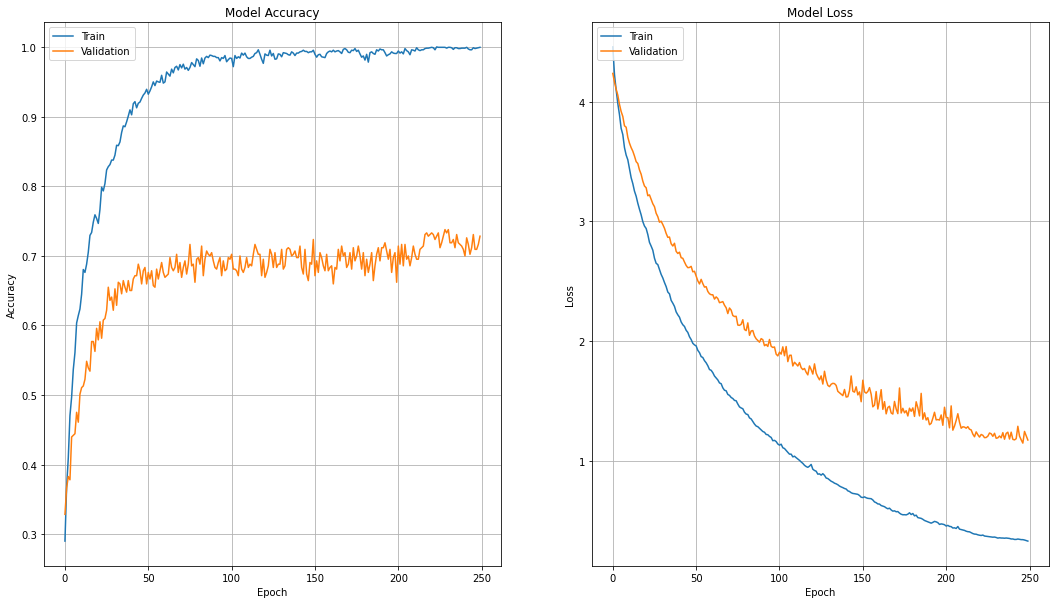

In [9]:
class AttentionLSTMIn(keras.layers.LSTM):
    """
    From: https://github.com/SPOClab-ca/SCNN/blob/master/SCNN/layers.py
    Keras LSTM layer (all keyword arguments preserved) with the addition of attention weights

    Attention weights are calculated as a function of the previous hidden state to the current LSTM step.
    Weights are applied either locally (across channels at current timestep) or globally (weight each sequence element
    of each channel).
    """
    ATT_STYLES = ['local', 'global']

    def __init__(self, units, alignment_depth: int = 1, style='local', alignment_units=None, implementation=2,
                 **kwargs):
        implementation = implementation if implementation > 0 else 2
        alignment_depth = max(0, alignment_depth)
        if isinstance(alignment_units, (list, tuple)):
            self.alignment_units = [int(x) for x in alignment_units]
            self.alignment_depth = len(self.alignment_units)
        else:
            self.alignment_depth = alignment_depth
            self.alignment_units = [alignment_units if alignment_units else units for _ in range(alignment_depth)]
        if style not in self.ATT_STYLES:
            raise TypeError('Could not understand style: ' + style)
        else:
            self.style = style
        super(AttentionLSTMIn, self).__init__(units, implementation=implementation, **kwargs)

    def build(self, input_shape):
        assert len(input_shape) > 2
        self.samples = input_shape[1]
        self.channels = input_shape[2]

        if self.style is self.ATT_STYLES[0]:
            # local attends over input vector
            units = [self.units + input_shape[-1]] + self.alignment_units + [self.channels]
        else:
            # global attends over the whole sequence for each feature
            units = [self.units + input_shape[1]] + self.alignment_units + [self.samples]
        self.attention_kernels = [self.add_weight(shape=(units[i-1], units[i]),
                                                name='attention_kernel_{0}'.format(i),
                                                initializer=self.kernel_initializer,
                                                regularizer=self.kernel_regularizer,
                                                trainable=True,
                                                constraint=self.kernel_constraint)
                                  for i in range(1, len(units))]

        if self.use_bias:
            self.attention_bias = [self.add_weight(shape=(u,),
                                                   name='attention_bias_{0}'.format(u),
                                                   trainable=True,
                                                   initializer=self.bias_initializer,
                                                   regularizer=self.bias_regularizer,
                                                   constraint=self.bias_constraint)
                                   for u in units[1:]]
        else:
            self.attention_bias = None
        super(AttentionLSTMIn, self).build(input_shape)

    def preprocess_input(self, inputs, training=None):
        self.input_tensor_hack = inputs
        return inputs

    def step(self, inputs, states):
        h_tm1 = states[0]

        if self.style is self.ATT_STYLES[0]:
            energy = K.concatenate((inputs, h_tm1))
        elif self.style is self.ATT_STYLES[1]:
            h_tm1 = K.repeat_elements(K.expand_dims(h_tm1), self.channels, -1)
            energy = K.concatenate((self.input_tensor_hack, h_tm1), 1)
            energy = K.permute_dimensions(energy, (0, 2, 1))
        else:
            raise NotImplementedError('{0}: not implemented'.format(self.style))

        for i, kernel in enumerate(self.attention_kernels):
            energy = K.dot(energy, kernel)
            if self.use_bias:
                energy = K.bias_add(energy, self.attention_bias[i])
            energy = self.activation(energy)

        alpha = K.softmax(energy)

        if self.style is self.ATT_STYLES[0]:
            inputs = inputs * alpha
        elif self.style is self.ATT_STYLES[1]:
            alpha = K.permute_dimensions(alpha, (0, 2, 1))
            weighted = self.input_tensor_hack * alpha
            inputs = K.sum(weighted, 1)

        return super(AttentionLSTMIn, self).step(inputs, states)
    
    
def RaSCNN(inputshape, outputshape, params=None):
    """
    Spatial summary convolutional neural network augmented with attention
    focused recurrence (Ra-SCNN) by Kostas, Pang, and Rudzics in "Machine
    learning for MEG during speec tasks."
    Adapted from https://github.com/SPOClab-ca/SCNN/blob/master/SCNN/models.py
    """
    ret_seq = True
    att_depth = 4
    attention = 76
    temp_layers = 4
    steps = 2
    temporal = 24
    temp_pool = 20

    lunits = [200, 40]
    activation = keras.activations.selu
    reg = float(0.01)
    dropout = 0.55

    convs = [inputshape[-1]//steps for _ in range(1, steps)]
    convs += [inputshape[-1] - sum(convs) + len(convs)]

    ins = keras.layers.Input(inputshape)
    conv = keras.layers.Reshape((inputshape[0], inputshape[1], 1))(ins)

    for i, c in enumerate(convs):
        conv = keras.layers.Conv2D(lunits[0]//len(convs), 
            (1, c), activation=activation,
            name='spatial_conv_{0}'.format(i),
            kernel_regularizer=tf.keras.regularizers.l2(reg))(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.SpatialDropout2D(dropout)(conv)

    for i in range(temp_layers):
        conv = keras.layers.Conv2D(lunits[1], (temporal, 1), activation=activation,
            use_bias=False, name='temporal_conv_{0}'.format(i),
            kernel_regularizer=tf.keras.regularizers.l2(reg))(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.AveragePooling2D((temp_pool, 1,))(conv)
    conv = keras.layers.SpatialDropout2D(dropout)(conv)
    conv = keras.layers.Reshape((45, 40))(conv)

    attn = keras.layers.Bidirectional(AttentionLSTMIn(attention,
        implementation=2,
        dropout=dropout,
        return_sequences=ret_seq,
        alignment_depth=att_depth,
        style='global',
        kernel_regularizer=tf.keras.regularizers.l2(reg),
        ))(conv)
    conv = keras.layers.BatchNormalization()(attn)

    if ret_seq:
        conv = keras.layers.Flatten()(conv)
    outs = conv
    for units in lunits[2:]:
        outs = keras.layers.Dense(units, activation=activation,
            kernel_regularizer=tf.keras.regularizers.l2(reg))(outs)
        outs = keras.layers.BatchNormalization()(outs)
        outs = keras.layers.Dropout(dropout)(outs)
    outs = keras.layers.Dense(outputshape, activation='softmax')(outs)

    return keras.models.Model(ins, outs)

# Compile model, using ADAM as the optimizer. Provide a summary once compiled.
model = SCNN(inputshape=(N_INPUT_SAMPLES, N_INPUT_CH), outputshape=4)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()

# Train our network with an 80/20 train/val split
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_rescnn.h5', 
        save_best_only=True,
        verbose=True,
        monitor='val_categorical_accuracy'
    ),
]
loss_hist = model.fit(
    X_train, y_train_1h,
    validation_data=(X_valid, y_valid_1h),
    batch_size=64,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
)

# Load our best weights and evaluate model on test dataset
model.load_weights('best_rescnn.h5')
print('\nTest accuracy')
print(model.evaluate(X_test, y_test_1h))

# Plot our loss and accuracy over time
fig, axs = plt.subplots(1,2, figsize=(18, 10))
axs[0].plot(loss_hist.history['categorical_accuracy'])
axs[0].plot(loss_hist.history['val_categorical_accuracy'])
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Model Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')
axs[0].grid()
axs[1].plot(loss_hist.history['loss'])
axs[1].plot(loss_hist.history['val_loss'])
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Model Loss')
axs[1].legend(['Train', 'Validation'], loc='upper left')
axs[1].grid()
plt.show()